In [ ]:
# PLANT LEAF DISEASE IDENTIFICATION 

import os
import cv2
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.cluster import KMeans


In [ ]:


DATASET_DIR = "/kaggle/input/plantdisease/PlantVillage"
WORK_DIR = "/kaggle/working/PlantVillage_Split_Improved"
os.makedirs(WORK_DIR, exist_ok=True)

IMAGE_SIZE = (256, 256)
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'

In [ ]:
# 2. IMAGE PREPROCESSING & SEGMENTATION
def preprocess_image(image):
    """Resize, denoise , and segment leaf."""
    image = cv2.resize(image, IMAGE_SIZE)
    # Bilateral filter preserves edges
    filtered = cv2.bilateralFilter(image, 9, 75, 75)
    # Convert to HSV
    hsv = cv2.cvtColor(filtered, cv2.COLOR_BGR2HSV)
    # AThresholding on gray image
    gray = cv2.cvtColor(filtered, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV,11,2)
    # Masking leaf
    masked = cv2.bitwise_and(filtered, filtered, mask=thresh)
    return masked

In [ ]:
# 3. FEATURE EXTRACTION
def extract_color_features(image):
    """RGB, HSV + Lab mean/std + 3D HSV histogram."""
    features = []
    # RGB mean/std
    for i in range(3):
        features.append(np.mean(image[:,:,i]))
        features.append(np.std(image[:,:,i]))
    # HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    for i in range(3):
        features.append(np.mean(hsv[:,:,i]))
        features.append(np.std(hsv[:,:,i]))
    # Lab
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    for i in range(3):
        features.append(np.mean(lab[:,:,i]))
        features.append(np.std(lab[:,:,i]))
    # 3D HSV histogram
    hist = cv2.calcHist([hsv],[0,1,2],None,[8,8,8],[0,180,0,256,0,256])
    cv2.normalize(hist, hist)
    features.extend(hist.flatten())
    return features

def extract_texture_features(image):
    """LBP + GLCM"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # LBP
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS+3), range=(0, LBP_POINTS+2))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-7)
    # GLCM
    glcm = graycomatrix(gray, distances=[1,3,5], angles=[0,np.pi/4,np.pi/2], levels=256, symmetric=True, normed=True)
    glcm_props = [np.mean(graycoprops(glcm, prop)) for prop in ['contrast','dissimilarity','homogeneity','energy','correlation']]
    return np.hstack([lbp_hist, glcm_props]).tolist()

def extract_shape_features(image):
    """Aspect ratio, extent, solidity + perimeter & circularity"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return [0,0,0,0,0]
    largest = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(largest)
    aspect_ratio = w/h if h!=0 else 0
    area = cv2.contourArea(largest)
    rect_area = w*h
    extent = area/rect_area if rect_area!=0 else 0
    hull = cv2.convexHull(largest)
    hull_area = cv2.contourArea(hull)
    solidity = area/hull_area if hull_area!=0 else 0
    perimeter = cv2.arcLength(largest,True)
    circularity = (4*np.pi*area)/(perimeter**2) if perimeter!=0 else 0
    return [aspect_ratio, extent, solidity, perimeter, circularity]

In [ ]:
# 4. FEATURE EXTRACTION LOOP and SAVE SEGMENTED IMAGES

print("Extracting features and saving segmented images...")
data, labels = [], []
class_folders = [f for f in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR,f))]

for folder in class_folders:
    folder_path = os.path.join(DATASET_DIR, folder)
    save_folder = os.path.join(WORK_DIR, folder)
    os.makedirs(save_folder, exist_ok=True)
    for file in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
        img_path = os.path.join(folder_path, file)
        image = cv2.imread(img_path)
        if image is None: continue
        # Preprocess and segment
        segmented = preprocess_image(image)
        cv2.imwrite(os.path.join(save_folder, file), segmented)
        # Extract features
        color_feats = extract_color_features(segmented)
        texture_feats = extract_texture_features(segmented)
        shape_feats = extract_shape_features(segmented)
        all_feats = color_feats + texture_feats + shape_feats
        data.append(all_feats)
        labels.append(folder)

print("Feature extraction complete.")


Extracting features and saving segmented images...


Processing Tomato_healthy: 100%|██████████| 1591/1591 [01:56<00:00, 13.66it/s]
Processing Tomato_Spider_mites_Two_spotted_spider_mite: 100%|██████████| 1676/1676 [02:03<00:00, 13.56it/s]
Processing Tomato__Tomato_mosaic_virus: 100%|██████████| 373/373 [00:26<00:00, 13.95it/s]

Feature extraction complete.


In [ ]:
# 5. TRAIN-TEST SPLIT & FEATURE SCALING
df = pd.DataFrame(data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels_encoded, test_size=0.2,
                                                    random_state=42, stratify=labels_encoded)

In [ ]:
# 6. RANDOM FOREST CLASSIFIER TRAINING
print("Training improved RandomForest model...")
clf = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Training improved RandomForest model...



Improved Model Accuracy: 95.20%

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.94      0.96       199
                     Pepper__bell___healthy       0.92      0.99      0.95       296
                      Potato___Early_blight       0.99      0.97      0.98       200
                       Potato___Late_blight       0.90      0.95      0.92       200
                           Potato___healthy       1.00      0.77      0.87        30
                      Tomato_Bacterial_spot       0.93      0.97      0.95       426
                        Tomato_Early_blight       0.94      0.84      0.89       200
                         Tomato_Late_blight       0.93      0.93      0.93       382
                           Tomato_Leaf_Mold       0.99      0.97      0.98       190
                  Tomato_Septoria_leaf_spot       0.95      0.92      0.93       354
Tomato_

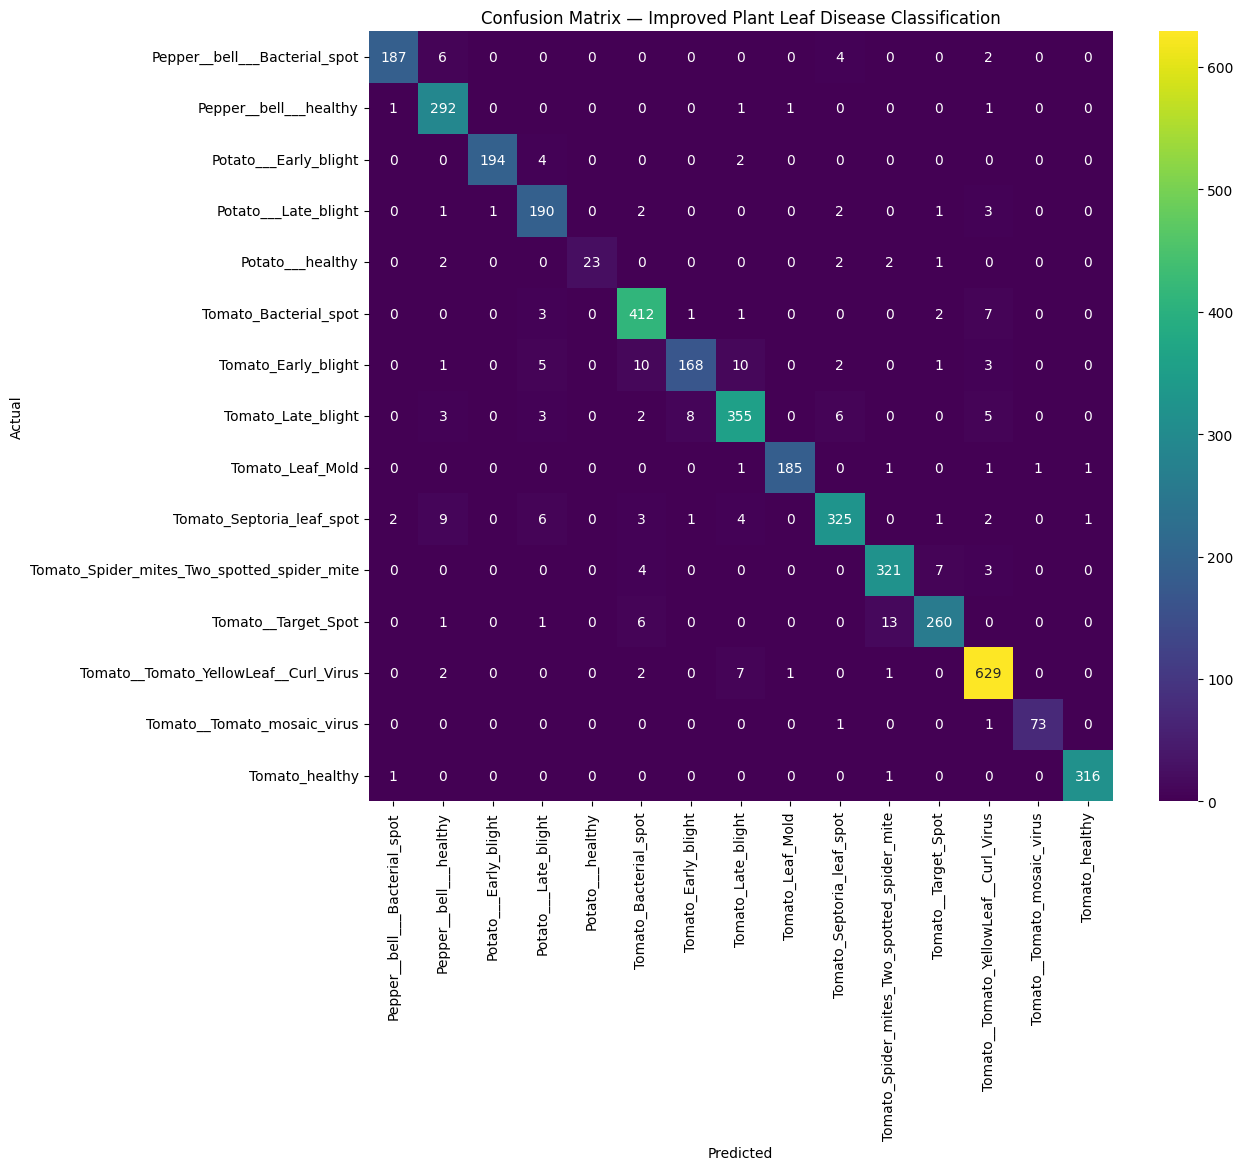

In [ ]:
# 7. EVALUATION
acc = accuracy_score(y_test, y_pred)
print(f"\nImproved Model Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='viridis')
plt.title("Confusion Matrix — Improved Plant Leaf Disease Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [28]:
joblib.dump(clf, os.path.join(WORK_DIR,"plant_disease_classifier_improved.joblib"))
joblib.dump(le, os.path.join(WORK_DIR,"label_encoder_improved.joblib"))
joblib.dump(scaler, os.path.join(WORK_DIR,"scaler_improved.joblib"))
print("\nImproved model, label encoder, and scaler saved successfully in:", WORK_DIR)


Improved model, label encoder, and scaler saved successfully in: /kaggle/working/PlantVillage_Split_Improved


In [30]:
!zip -r my_output_archive_Improved.zip /kaggle/working/PlantVillage_Split_Improved/


  adding: kaggle/working/PlantVillage_Split_Improved/ (stored 0%)
  adding: kaggle/working/PlantVillage_Split_Improved/Tomato_Septoria_leaf_spot/ (stored 0%)
  adding: kaggle/working/PlantVillage_Split_Improved/Tomato_Septoria_leaf_spot/491d430e-fdc0-4235-8632-bf41b3455fc5___Matt.S_CG 7784.JPG (deflated 1%)
  adding: kaggle/working/PlantVillage_Split_Improved/Tomato_Septoria_leaf_spot/50cb3118-d96b-4805-b975-99a443575a64___Matt.S_CG 7409.JPG (deflated 1%)
  adding: kaggle/working/PlantVillage_Split_Improved/Tomato_Septoria_leaf_spot/9604c3d8-1ccd-4aea-8e31-b90ad17bdae1___JR_Sept.L.S 8406.JPG (deflated 1%)
  adding: kaggle/working/PlantVillage_Split_Improved/Tomato_Septoria_leaf_spot/3d91b473-6309-4310-9acd-e66dacaf789f___Keller.St_CG 1991.JPG (deflated 1%)
  adding: kaggle/working/PlantVillage_Split_Improved/Tomato_Septoria_leaf_spot/4463e85e-f583-41ae-8261-8cc9b5ac3850___Matt.S_CG 7560.JPG (deflated 1%)
  adding: kaggle/working/PlantVillage_Split_Improved/Tomato_Septoria_leaf_spot/74b